In [14]:
# Install necessary packages
%pip install idx2numpy
%pip install tensorflow  # or keras, depending on your framework
%pip install torch torchvision torchaudio  # for PyTorch
%pip install ipykernel  # Install ipykernel for Jupyter
%pip install effdet


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import idx2numpy
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import ViTModel, ViTConfig

# Load training data
train_images = idx2numpy.convert_from_file('/Users/chamaththiwanka/Desktop/Kaggle/app/Dataset/Train/train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('/Users/chamaththiwanka/Desktop/Kaggle/app/Dataset/Train/train-labels.idx1-ubyte')

# Load test data
test_images = idx2numpy.convert_from_file('/Users/chamaththiwanka/Desktop/Kaggle/app/Dataset/Test/t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('/Users/chamaththiwanka/Desktop/Kaggle/app/Dataset/Test/t10k-labels.idx1-ubyte')

# Check the shape of the loaded data
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [16]:
# Normalize the images to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Reshape the images to add a channel dimension (for CNNs)
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
# ViT for MNIST (PyTorch)

# Check if GPU is available and set the device accordingly

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = ViTConfig(
    image_size=28,
    patch_size=7,
    num_classes=10,
    hidden_size=128,
    num_hidden_layers=4,
    num_attention_heads=4,
    num_channels=1  # Set to 1 for grayscale images
)
model = ViTModel(config).to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [21]:
# Training loop
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Ensure the shape is (batch_size, num_channels, height, width)
        images = images.permute(0, 3, 1, 2)  # Change from (batch_size, height, width, num_channels) to (batch_size, num_channels, height, width)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)  # Get the model output
        logits = outputs.last_hidden_state[:, 0]  # Use the first token's hidden state for classification
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/10], Loss: 0.5462
Epoch [2/10], Loss: 0.1959
Epoch [3/10], Loss: 0.1426
Epoch [4/10], Loss: 0.1116
Epoch [5/10], Loss: 0.0960
Epoch [6/10], Loss: 0.0823
Epoch [7/10], Loss: 0.0709
Epoch [8/10], Loss: 0.0663
Epoch [9/10], Loss: 0.0585
Epoch [10/10], Loss: 0.0536


In [24]:
# Testing loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Ensure the shape is (batch_size, num_channels, height, width)
        images = images.permute(0, 3, 1, 2)  # Change from (batch_size, height, width, num_channels) to (batch_size, num_channels, height, width)
        
        # Zero the parameter gradients
        outputs = model(images)  # Get the model output
        logits = outputs.last_hidden_state[:, 0]  # Use the first token's hidden state for classification
        _, predicted = torch.max(logits.data, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 97.77%


In [40]:
torch.save(model.state_dict(), 'efficientdet_model.pth')

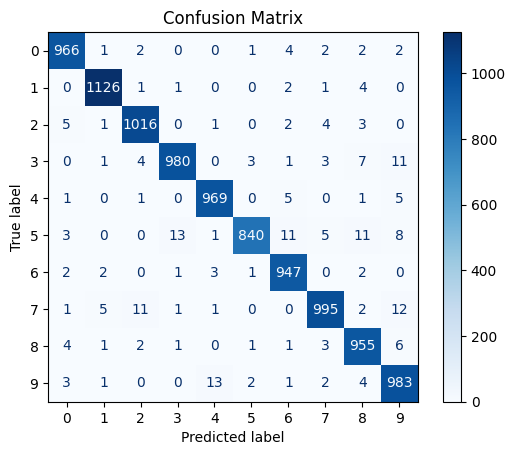

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have the true labels and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Ensure the shape is (batch_size, num_channels, height, width)
        images = images.permute(0, 3, 1, 2)  # Change from (batch_size, height, width, num_channels) to (batch_size, num_channels, height, width)
        
        outputs = model(images)  # Get the model output
        logits = outputs.last_hidden_state[:, 0]  # Use the first token's hidden state for classification
        _, predicted = torch.max(logits.data, 1)  # Get the predicted class
        
        y_true.extend(labels.cpu().numpy())  # Collect true labels
        y_pred.extend(predicted.cpu().numpy())  # Collect predicted labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

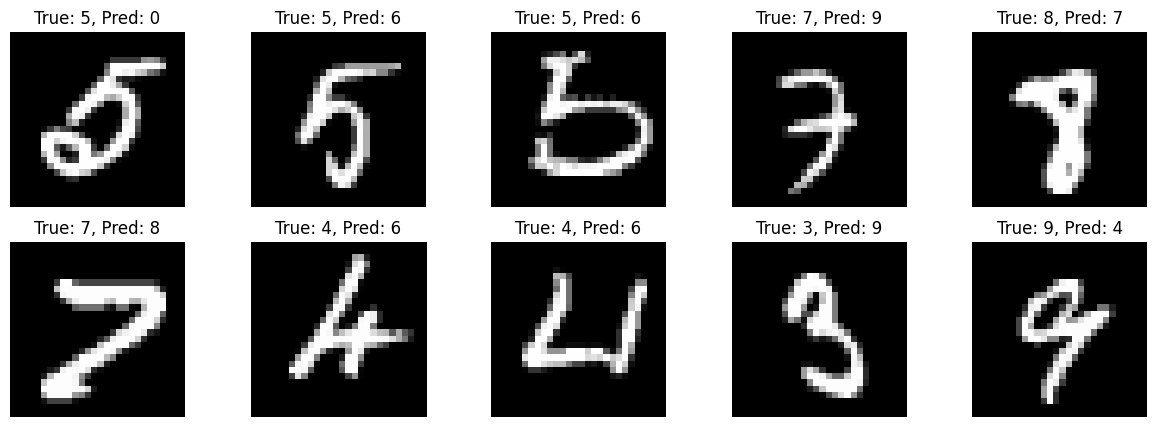

In [43]:
import matplotlib.pyplot as plt

def visualize_misclassifications(images, true_labels, predicted_labels, num_images=10):
    misclassified_indices = [i for i in range(len(true_labels)) if true_labels[i] != predicted_labels[i]]
    selected_indices = np.random.choice(misclassified_indices, num_images, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f'True: {true_labels[idx]}, Pred: {predicted_labels[idx]}')
        plt.axis('off')
    plt.show()

# Call the function with your test images and labels
visualize_misclassifications(test_images_tensor.cpu().numpy(), y_true, y_pred)